# Auxiliary SVI Data Analysis

The objective of this workbook is to measure the multicollinearity of the input datasets by:

- Calculating the pairwise Pearson correlation coefficients between the variables in the input datasets.
- Checking the VIF scores of the variables in the input datasets.

The results of the above will help us understand the multicollinearity degree of the input datasets, as well as helps us to determine wether it is necessary to drop some of the highly correlated variables in the datasets. 

### Import All Necessary Libraries

Uncomment the following line to install the required libraries

In [1]:
#!pip install -r requirements.txt

Import all necessary libraries

In [2]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
from urllib.request import urlopen
import json
import warnings
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore', category=RuntimeWarning)

## Data Collection and Cleaning

### Load and Inspect Data

PLACES data: https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-Census-Tract-D/cwsq-ngmh/about_data

In [3]:
# Load API data
url = "https://data.cdc.gov/resource/cwsq-ngmh.json"  # CDC API URL
params = {
    "$limit": 1000000,  # Increase limit to load all data
    "year": "2022",
    "measure": "Current asthma among adults"
}
response = requests.get(url, params=params)
data = response.json()

# Convert to a pandas DataFrame
asthma_df = pd.DataFrame(data)

# Keep only the required columns
asthma_df = asthma_df[['stateabbr', 'statedesc', 'countyname', 'locationname', 'data_value']]
asthma_df.rename(columns={'data_value': 'asthma_prevalence'}, inplace=True)
asthma_df['asthma_prevalence'] = pd.to_numeric(asthma_df['asthma_prevalence'], errors='coerce') / 100

# Display the dataframe
asthma_df

,stateabbr,statedesc,countyname,locationname,asthma_prevalence
0,FL,Florida,Miami-Dade,12086009907,0.100
1,FL,Florida,Miami-Dade,12086003705,0.076
2,FL,Florida,Miami-Dade,12086011800,0.086
3,FL,Florida,Miami-Dade,12086012101,0.090
4,FL,Florida,Miami-Dade,12086007705,0.078
...,...,...,...,...,...
83517,FL,Florida,Marion,12083001208,0.101
83518,FL,Florida,Marion,12083001205,0.094
83519,FL,Florida,Manatee,12081002003,0.094
83520,FL,Florida,Leon,12073000303,0.124


States by region stripped from: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf

In [4]:
region_df = pd.read_csv("Region.csv")
region_df

,StateAbbr,Region
0,AL,South
1,AZ,West
2,AR,South
3,CA,West
4,CO,West
5,CT,Northeast
6,DE,South
7,DC,South
8,FL,South
9,GA,South


SVI data: https://www.atsdr.cdc.gov/place-health/php/svi/svi-data-documentation-download.html

In [5]:
# Load the SVI dataset
data_file = 'SVI_2022_US.csv'
svi_df = pd.read_csv(data_file)

# Drop the first five columns, the seventh column, and the eighth column from svi_df
columns_to_drop = svi_df.columns[:5].tolist() + [svi_df.columns[6], svi_df.columns[7]]
svi_df = svi_df.drop(columns=columns_to_drop)

# Display the dataframe
svi_df

,FIPS,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV150,M_POV150,E_UNEMP,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
0,1001020100,1865,368,733,114,700,114,402,184,19,...,2.4,3.4,0.0,2.0,0.0,2.0,5.5,4.2,0.0,2.0
1,1001020200,1861,396,680,97,544,101,239,144,51,...,0.0,2.0,0.0,2.0,0.0,2.0,7.3,6.3,0.4,0.9
2,1001020300,3492,593,1431,213,1305,227,773,335,33,...,0.3,0.5,0.0,1.1,0.0,1.1,4.2,5.2,0.0,1.1
3,1001020400,3987,411,1722,211,1666,219,514,235,17,...,0.6,0.6,0.2,0.3,0.0,0.9,2.9,2.6,0.0,0.9
4,1001020501,4121,709,1857,283,1783,304,412,196,14,...,2.4,4.1,0.0,0.9,0.0,0.9,1.0,1.3,0.0,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84115,56043000200,3028,182,1580,136,1367,136,483,170,31,...,0.6,0.8,0.3,0.5,0.0,1.2,2.0,1.5,0.1,0.1
84116,56043000301,2323,246,1128,102,948,128,485,198,5,...,0.0,1.6,0.3,0.5,0.0,1.6,2.6,2.5,0.8,1.0
84117,56043000302,2374,270,1148,108,1099,117,475,243,36,...,0.5,0.9,0.3,0.8,0.0,1.6,5.1,3.1,0.0,1.6
84118,56045951100,3275,171,1557,130,1373,136,823,348,73,...,0.0,0.1,1.1,1.6,0.0,1.1,13.0,8.0,0.2,0.4


EPA data for environmental factors: https://data.cdc.gov/Environmental-Health-Toxicology/Daily-Census-Tract-Level-PM2-5-Concentrations-2016/96sd-hxdt/data_preview

In [6]:
# Load the API data
url = "https://data.cdc.gov/resource/96sd-hxdt.json"
params = {
    "$limit": 1000000,  # Increase limit to load all data
    "date": "31DEC2020"
}
response = requests.get(url, params=params)
data = response.json()

# Convert to a pandas DataFrame
epa_df = pd.DataFrame(data)

# Drop the specified columns from epa_df
epa_df = epa_df.drop(columns=['year', 'date', 'statefips', 'countyfips', 'latitude', 'longitude'])

# Display the dataframe
epa_df

,ctfips,ds_pm_pred,ds_pm_stdd
0,1001020100,15.523,10.7042
1,1001020200,15.433,10.3854
2,1001020300,15.999,11.138
3,1001020400,15.515,10.5776
4,1001020501,15.875,11.0316
...,...,...,...
83771,56043000200,1.807,1.1694
83772,56043000301,2.355,1.5672
83773,56043000302,2.326,1.4547
83774,56045951100,2.058,1.4051


### Combine and Clean the Datasets

In [7]:
# Combine the region with the asthma_df
asthma_df = asthma_df.merge(region_df, left_on='stateabbr', right_on='StateAbbr', how='left')

# Drop the duplicate column 'StateAbbr'
asthma_df = asthma_df.drop(columns=['StateAbbr'])

# Reorder the columns to ensure 'Region' is the first column
columns_order = ['Region'] + [col for col in asthma_df.columns if col != 'Region']
asthma_df = asthma_df[columns_order]

# Combine asthma_df, svi_df, and epa_df on the census tract FIPS code
# Ensure the data types of the columns being merged on match
asthma_df['locationname'] = asthma_df['locationname'].astype(str)
svi_df['FIPS'] = svi_df['FIPS'].astype(str)

# Merge the asthma and svi datasets
combined_df = asthma_df.merge(svi_df, left_on='locationname', right_on='FIPS', how='inner')

# Ensure the data types of columns being merged on match for the epa dataset
epa_df['ctfips'] = epa_df['ctfips'].astype(str)

# Merge combined_df (asthma + svi) with epa_df on asthma_df.locationname = svi_df.FIPS = epa_df.ctfips
final_combined_df = combined_df.merge(epa_df, left_on='locationname', right_on='ctfips', how='inner')
final_combined_df = final_combined_df.drop(columns=['ctfips', 'locationname'])
columns_order = ['FIPS'] + [col for col in final_combined_df.columns if col != 'FIPS']
asthma_df = final_combined_df[columns_order]

# Removing any rows with no population, and any rows with negative values 
final_combined_df = final_combined_df[
    (final_combined_df['E_TOTPOP']>0) & ~(final_combined_df==-999).any(axis=1)
].reset_index(drop=True)

# Display the final combined dataframe
final_combined_df

,Region,stateabbr,statedesc,countyname,asthma_prevalence,FIPS,E_TOTPOP,M_TOTPOP,E_HU,M_HU,...,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,ds_pm_pred,ds_pm_stdd
0,South,FL,Florida,Miami-Dade,0.100,12086009907,4120,971,1188,194,...,0.0,1.2,0.0,1.2,1.2,1.9,0.8,1.2,8.015,3.1296
1,South,FL,Florida,Miami-Dade,0.076,12086003705,1746,289,1399,93,...,0.0,2.8,0.0,2.8,14.2,6.2,1.0,1.7,6.203,2.5102
2,South,FL,Florida,Miami-Dade,0.086,12086011800,3521,734,1110,171,...,0.0,1.4,0.0,1.4,0.2,0.5,1.6,1.9,7.986,3.3325
3,South,FL,Florida,Miami-Dade,0.090,12086012101,2987,875,1271,386,...,0.0,1.7,0.0,1.7,0.0,1.7,0.0,1.7,7.913,3.273
4,South,FL,Florida,Miami-Dade,0.078,12086007705,5120,582,2515,248,...,0.0,1.0,0.0,1.0,0.9,1.2,0.4,0.6,6.455,2.9832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67363,South,FL,Florida,Marion,0.101,12083001208,3891,679,1863,168,...,0.0,1.3,0.0,1.3,0.6,0.8,0.0,1.3,9.504,5.3214
67364,South,FL,Florida,Marion,0.094,12083001205,4279,450,2211,184,...,0.0,1.2,0.0,1.2,2.2,1.9,0.0,1.2,9.424,5.231
67365,South,FL,Florida,Manatee,0.094,12081002003,6144,1230,3379,407,...,0.0,0.8,0.0,0.8,4.7,2.9,0.0,0.8,9.398,4.2423
67366,South,FL,Florida,Leon,0.124,12073000303,5030,968,2097,232,...,0.0,1.0,0.0,1.0,2.1,1.8,0.5,0.8,10.991,7.7057


## Exploratory Data Analysis

In [8]:
# Checking for missing values
missing_values = final_combined_df.isnull().sum()

# Display the missing values
print(missing_values)

Region               0
stateabbr            0
statedesc            0
countyname           0
asthma_prevalence    0
                    ..
MP_TWOMORE           0
EP_OTHERRACE         0
MP_OTHERRACE         0
ds_pm_pred           0
ds_pm_stdd           0
Length: 158, dtype: int64


There are no missing values, in the 158 columns of our dataset, signaling that there is no need for data imputation. 

In [9]:
# Shape of the dataset
print(final_combined_df.shape)

# Checking for duplicates
print( final_combined_df.duplicated().sum())

# Data types
print(final_combined_df.dtypes)
print(final_combined_df.select_dtypes('object').columns)
final_combined_df['ds_pm_pred'] = pd.to_numeric(final_combined_df['ds_pm_pred'], errors='coerce')
final_combined_df['ds_pm_stdd'] = pd.to_numeric(final_combined_df['ds_pm_stdd'], errors='coerce')

(67368, 158)
0
Region                object
stateabbr             object
statedesc             object
countyname            object
asthma_prevalence    float64
                      ...   
MP_TWOMORE           float64
EP_OTHERRACE         float64
MP_OTHERRACE         float64
ds_pm_pred            object
ds_pm_stdd            object
Length: 158, dtype: object
Index(['Region', 'stateabbr', 'statedesc', 'countyname', 'FIPS', 'ds_pm_pred',
       'ds_pm_stdd'],
      dtype='object')


Our dataset contains 67,368 rows and 158 columns. There are no duplicates and we converted the ds_pm_pred, ds_pm_stdd values to numerical formats, allowing them to be used for later learning algorithm stages. 

In [10]:
# Save the list of unique column names to a CSV file
unique_columns_df = pd.DataFrame(final_combined_df.columns, columns=['Column Names'])
unique_columns_df.to_csv('unique_columns.csv', index=False)

The list of unique column names has been saved to a CSV file named `unique_columns.csv` to be referenced in the appendix.

## Multicollinearity Check

Now, let's check for multicollinearity in our dataset.
First, we will start with checking the VIF values for each feature. 

In [11]:
# Using the original features
X = final_combined_df.drop(columns=['Region', 'stateabbr', 'statedesc', 'countyname', 'FIPS'])


X = X.astype({col: 'float64' for col in X.select_dtypes(include='bool').columns})

# Add a constant column (intercept) — required for VIF calc
X_const = add_constant(X)

# Calculate the VIF for each feature
vif = pd.DataFrame()
vif['Feature'] = X_const.columns
vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

As we can see below, we are seeing many features with high VIF values, some even with infinity VIF values.
Generally speaking, a VIF score greater than 5 indicates that the feature is highly correlated with other features in the dataset. In the combined dataset we have, there are 150 features with VIF values greater than 5, and 133 features with VIF values greater than 10. All of them are from the SVI dataset.

In [12]:
print('='*100)
print('VIF values distribution: ')
print(vif.describe())
print('='*100)

print('Number of features with VIF > 5: ', len(vif[vif['VIF'] > 5]))
print('Number of features with VIF > 10: ', len(vif[vif['VIF'] > 10]))

VIF values distribution: 
              VIF
count  154.000000
mean          inf
std           NaN
min      1.349844
25%     13.523214
50%     27.593075
75%           NaN
max           inf
Number of features with VIF > 5:  150
Number of features with VIF > 10:  133


In [13]:
print('Features with VIF > 10:')
vif[vif['VIF'] > 10]

Features with VIF > 10:


,Feature,VIF
0,const,798.206394
2,E_TOTPOP,116.650240
3,M_TOTPOP,46.865200
4,E_HU,14.071473
5,M_HU,20.105589
...,...,...
147,MP_NHPI,19.615029
148,EP_TWOMORE,2040.077994
149,MP_TWOMORE,16.155968
150,EP_OTHERRACE,324.361310


Next, we will also review the Pearson correlation between the features.

Correlation Matrix on Features


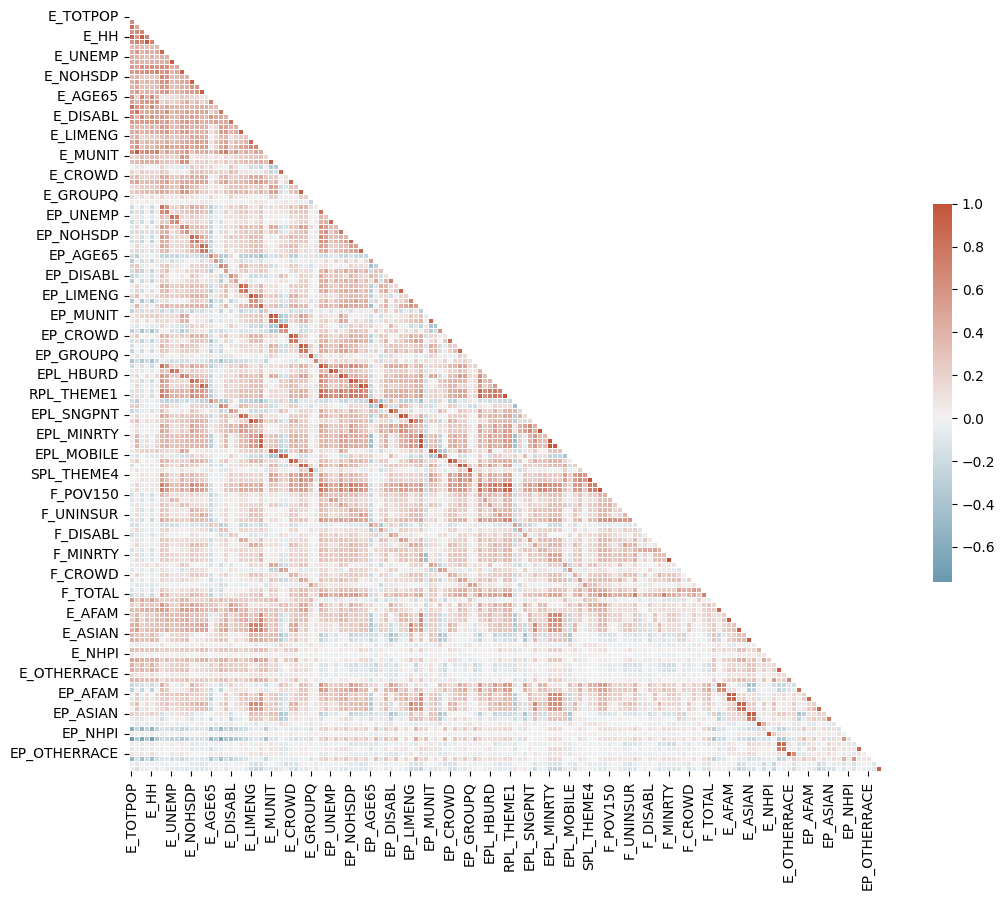

In [14]:
# Correlation Matrix on Features
X = final_combined_df.drop(columns=['asthma_prevalence', 'Region', 'stateabbr', 'statedesc', 'countyname', 'FIPS'])
y = final_combined_df['asthma_prevalence']


# Compute the correlation matrix
corr = X.corr(method="spearman") # Spearman picked because it shows non-parametric correlations and handles ties well.

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.tight_layout()

print('Correlation Matrix on Features')
plt.show()

Similar to the VIF scores, we are also seeing that many features have extremely high Pearson correlation values with other features in the dataset. This makes sense because, if we look at the description of these features in the SVI dataset documentation (https://svi.cdc.gov/map25/data/docs/SVI2022Documentation_ZCTA.pdf), we can see that many fields are measuring the same aspect of social vulnerability in different forms, such as percentage, absolute value, or percentile. For this reason, we will drop these redundant features in our main model pipeline to address the multicollinearity issue.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=32f7fcbd-ed69-45a9-89b9-6a8497955dec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>